# Meta-analysis (and other tools)
Throwing everything I can think of at this dataset and putting it in one place...

### Shopping list

**Data exploration**
- Visualise discrepancies in units (for raw data, no ones): counts by unit, unit distributions
  - All units, pre-standardisation
  - Post-standardised units
  
**Meta-analysis**


#### Questions for Oscar
- How does the `pH_scale_converter` function convert using temperature and salinity alone? Are there major assumptions here? How accurate is it? I was under the impression that you need another carbonate parameter, but I guess this is just for calculating the rest of the carbonate system

In [37]:
### autoreload
%reload_ext autoreload
%autoreload 2

### import
# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# custom
from calcification import analysis, utils, plotting, config, processing

In [56]:
### process raw data
carbonate_df = processing.populate_carbonate_chemistry(
    fp=config.data_dir / 'Orlando_data.xlsx',
    sheet_name='all_data',
    selection_dict={'include': 'yes'})
print(f"\nShape of dataframe with all rows marked for inclusion: {carbonate_df.shape}")


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0']
Found extra locations (not already in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml


Querying Google Maps to retrieve coordinates of locations:   0%|          | 0/88 [00:00<?, ?it/s]

Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml
Loading measured values...


Calculating carbonate chemistry:   0%|          | 0/3396 [00:00<?, ?it/s]


Shape of dataframe with all rows marked for inclusion: (3396, 82)


In [39]:
### basic processing to get ready for assigning effect sizes
# assign treatment groups
carbonate_df_tgs = processing.assign_treatment_groups_multilevel(carbonate_df)
print(f"\nShape of dataframe with treatment groups: {carbonate_df_tgs.shape}")
n1_rows = len(carbonate_df_tgs[carbonate_df_tgs['n'] == 1])
# grouping any samples with samples of n=1
carbonate_df_tgs_no_ones = processing.aggregate_treatments_with_individual_samples(carbonate_df_tgs)
print(f"\nShape of dataframe with treatment groups and grouped n=1 rows: {carbonate_df_tgs_no_ones.shape}. \nOriginal had {n1_rows} n=1 rows.")
working_df = carbonate_df_tgs_no_ones.copy()

Assigning treatment groups:   0%|          | 0/315 [00:00<?, ?it/s]


Shape of dataframe with treatment groups: (3396, 87)

Shape of dataframe with treatment groups and grouped n=1 rows: (1602, 87). 
Original had 1915 n=1 rows.


In [ ]:
### data summary
# number of studies
print(f'Number of studies: {len(working_df["original_doi"].unique())}')
# number of distinct locations
print(f'Number of distinct named locations: {len(working_df["location"].unique())}')
print(f'Number of distinct locations (by coordinate pair): {working_df.groupby(['latitude', 'longitude']).ngroups}')
print(f'Number of visits to a unique location (e.g. including times when studies have used the same location): {working_df.doi.nunique()}')

### I'm waiting on judgement re some, to revisit other to extract additional/correct data
check_waiting_df = pd.read_excel(
    config.data_dir / 'Orlando_data.xlsx',
    sheet_name='all_data',
)

# Filter first, then group and count
filtered = check_waiting_df[check_waiting_df['Include'].isin(['revisit', 'check'])]
count_per_doi = filtered.groupby('DOI').size()
print(f'Number of studies marked as "revisit" or "check": {len(count_per_doi)} corresponding to {len(filtered)} rows.')


Number of studies: 120
Number of distinct named locations: 113
Number of distinct locations (by coordinate pair): 114
Number of visits to a unique location (e.g. including times when studies have used the same location): 150
Number of studies marked as "revisit" or "check": 33 corresponding to 2722 rows.


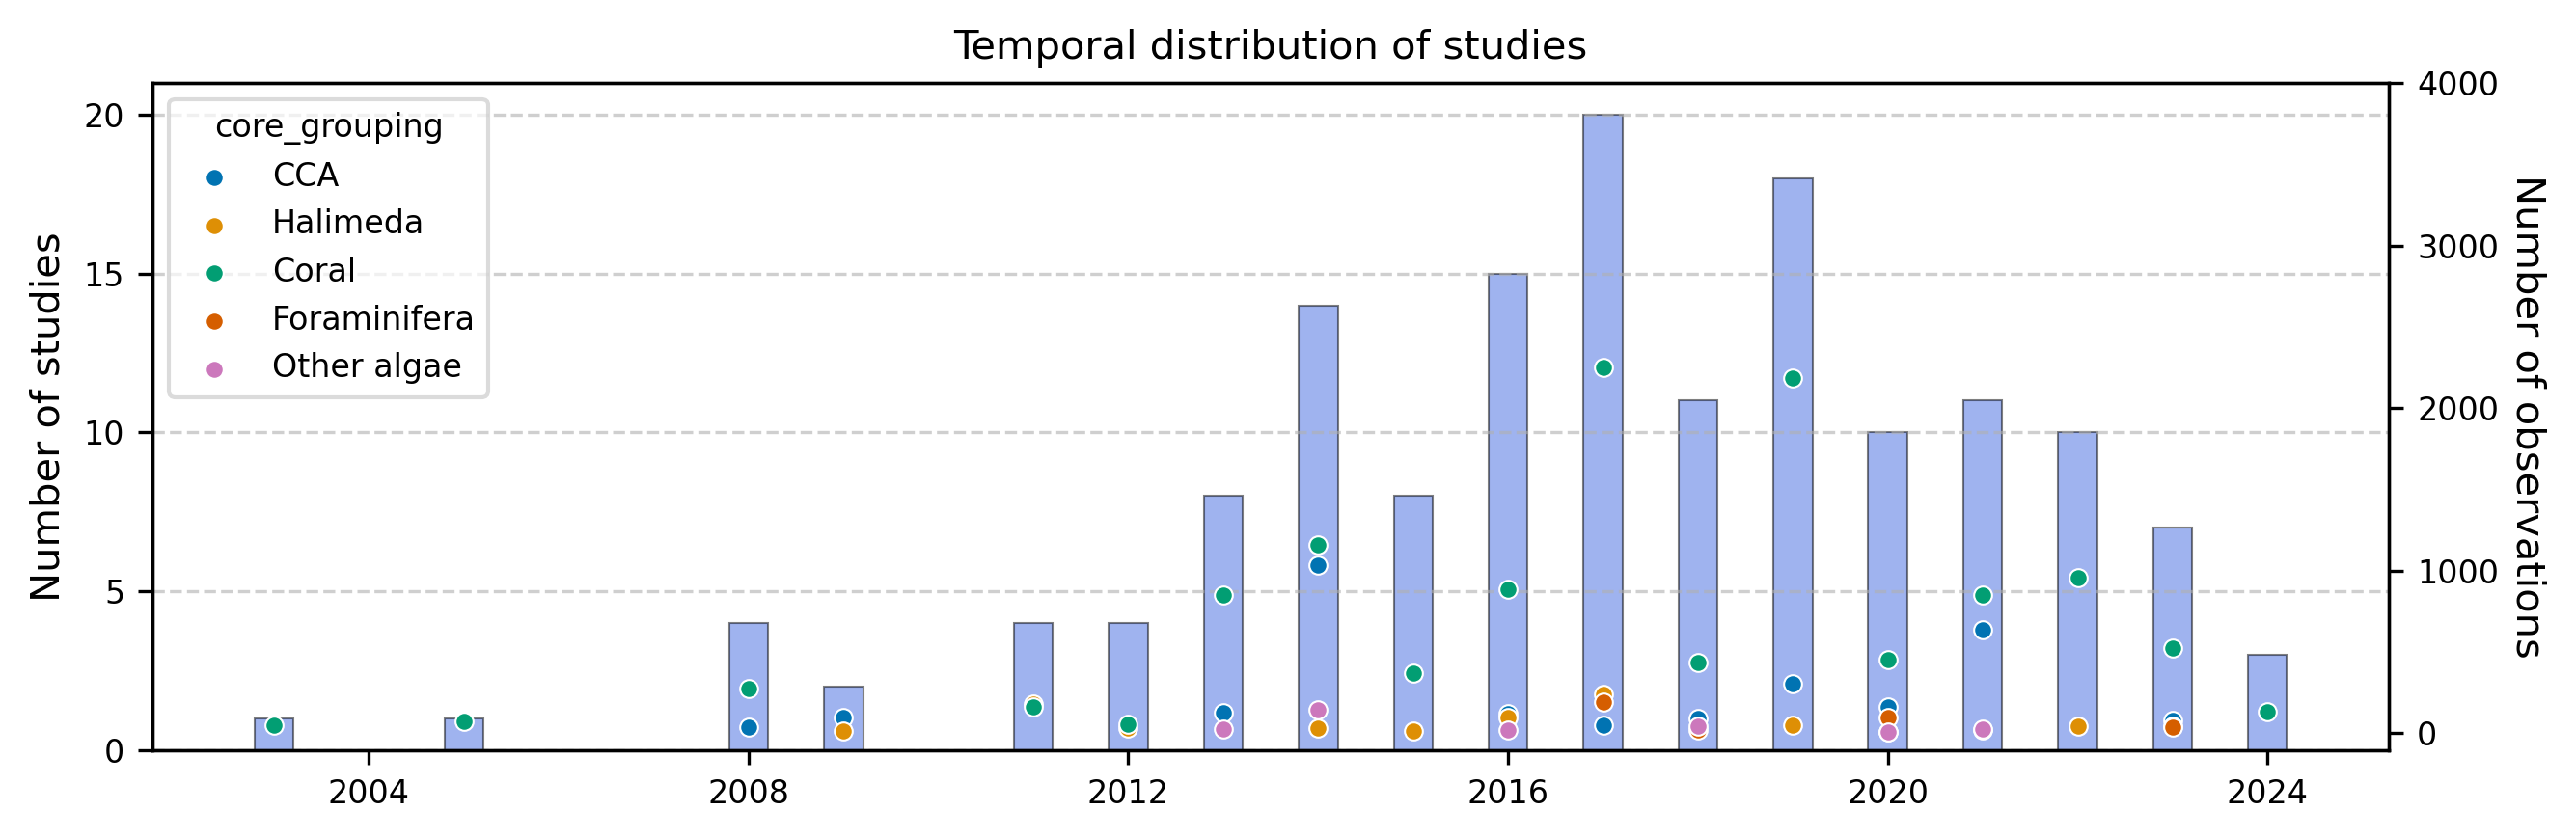

In [ ]:
### plot temporal distribution of studies, broken down by species
plotting.plot_study_timeseries(working_df, colorby='core_grouping');

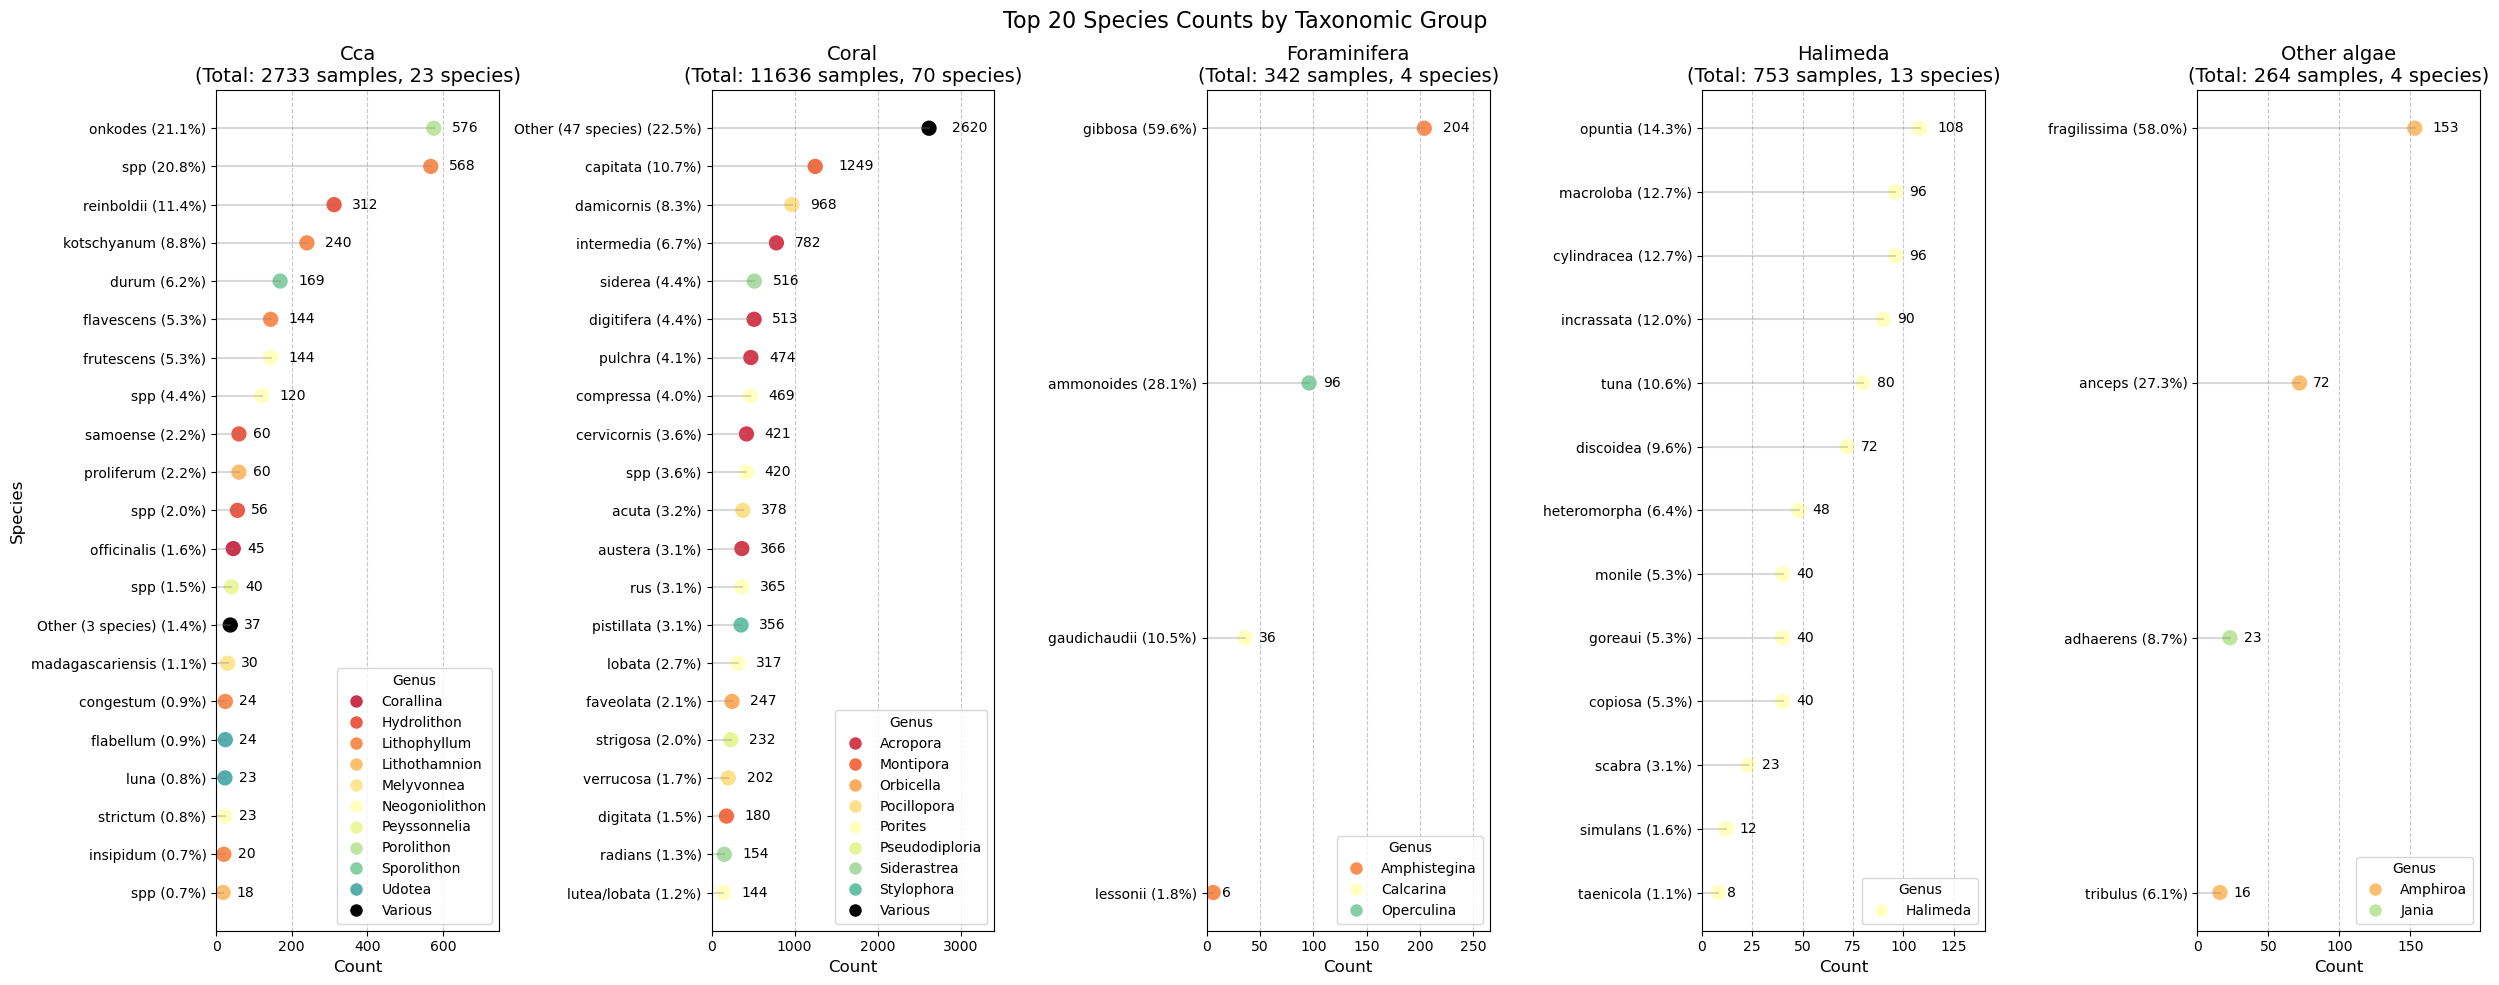

In [44]:
### plot taxonomic distribution of study organisms
plotting.create_faceted_dotplot_with_percentages(working_df, top_n=20, groupby='core_grouping');

## Units

- Standardising before calculating effects e.g. Hedges G makes no difference since a relative measure? But perhaps changing SDs change it... Will test

### Occurences

Number of different calcification units: 88


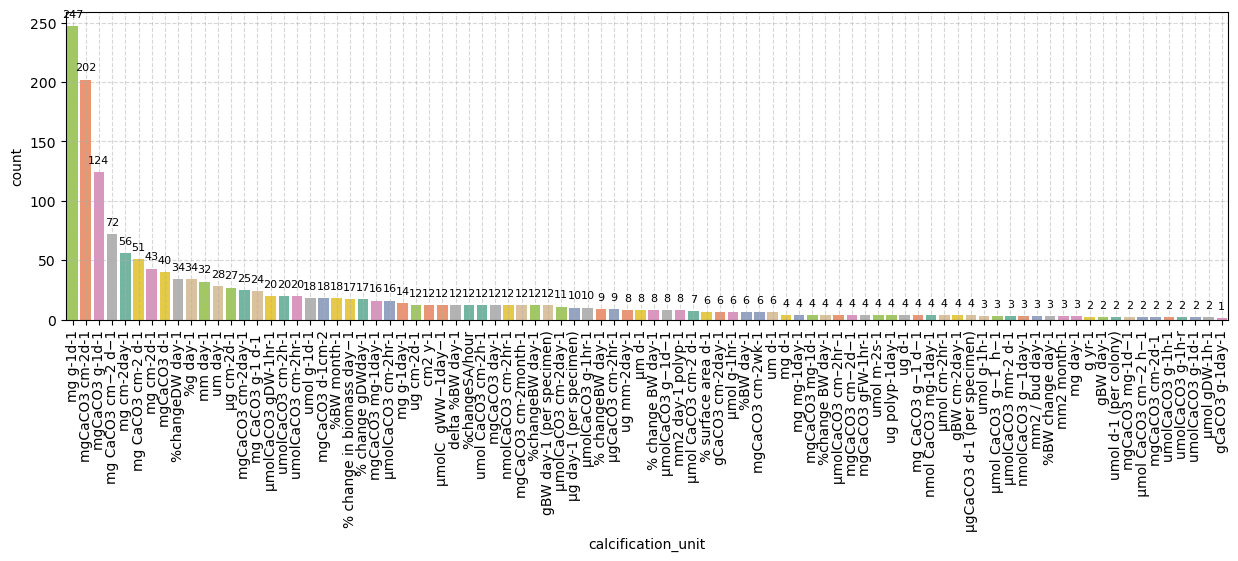

In [45]:
### raw units
plt.figure(figsize=(15, 4))
count_order = working_df['calcification_unit'].value_counts().index # sort by number of counts for each calcification unit
sns.countplot(data=working_df, x='calcification_unit', order=count_order, palette='Set2', hue='calcification_unit')
plt.xticks(rotation=90)
plt.grid(ls='--', alpha=0.5)
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points')
print(f'Number of different calcification units: {len(working_df["calcification_unit"].unique())}')

In [ ]:
### standardised units
plt.figure(figsize=(15, 4))
count_order = working_df['st_calcification_unit'].value_counts().index # sort by number of counts for each calcification unit
sns.countplot(data=working_df, x='st_calcification_unit', order=count_order, palette='Set2', hue='st_calcification_unit')
plt.xticks(rotation=90);
plt.grid(ls='--', alpha=0.5)
# plot numbers at the top of the bars
for p in plt.gca().patches:
    plt.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
print(f'Number of distinct types of calcification measurement: {len(working_df["st_calcification_unit"].unique())}')

In [ ]:
### standardised units with total samples (n)
plt.figure(figsize=(15, 4))

# Group by 'st_calcification_unit' and sum the 'n' column
unit_counts = working_df.groupby('st_calcification_unit')['n'].sum().sort_values(ascending=False)

# Plot the data
sns.barplot(x=unit_counts.index, y=unit_counts.values, palette='Set2', hue=unit_counts.index)
plt.xticks(rotation=90)
plt.grid(ls='--', alpha=0.5)

# Annotate the bars with the total counts
for i, value in enumerate(unit_counts.values):
    plt.annotate(f'{int(value)}', (i, value), ha='center', va='bottom', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

print(f'Number of distinct types of calcification measurement: {len(unit_counts)}')

### Distributions

In [ ]:
# TODO: check this conversion rate
### visualise distributions of various calcification rates
rate_type_mapping = {
    'mgCaCO3 cm-2d-1': r'$mg \, CaCO_3 \, cm^{-2} \, d^{-1}$',
    'mgCaCO3 g-1d-1': r'$mg \, CaCO_3 \, g^{-1} \, d^{-1}$',
    'delta mass d-1': r'$\Delta mass\, d^{-1}$',
    'mg d-1': r'$mg \, d^{-1}$',
    'm2 d-1': r'$m^2 \, d^{-1}$',
    'm d-1': r'$m \, d^{-1}$',
    'deltaSA d-1': r'$\Delta SA \, d^{-1}$'
}

rate_types = working_df['st_calcification_unit'].unique()
rate_types = [rate_type for rate_type in rate_types if rate_type != ""]
fig, axes = plt.subplots(len(rate_types), 1, figsize=(5, 8), dpi=300)

for i, rate_type in enumerate(rate_types):
    # absolute calcification
    axes[i].hist(working_df[working_df['st_calcification_unit'] == rate_type]['st_calcification'], bins=100)
    axes[i].set_title(f"{rate_type_mapping.get(rate_type, rate_type)}", fontsize=8)
    
# format
for ax in axes.flatten():
    if max([p.get_height() for p in ax.patches]) > 10:
        ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=6)  # Adjust label size for both axes
    
plt.suptitle('Absolute calcification rates and their effect sizes', fontsize=10)
plt.tight_layout()

## Climatology

In [ ]:
# TODO: fix these figures
missing_coords = working_df[working_df.latitude.isna() | working_df.longitude.isna()]
print(f"Number of rows without lat/lon coordinates: {len(missing_coords)}.")
print(f"These correspond to the following locations: {missing_coords.drop_duplicates('doi', keep='first').location.values}.")

aquaria_locations = working_df[working_df['location'].str.lower().str.contains('aquar', na=False)]
additional_rows = set(aquaria_locations.drop_duplicates('doi', keep='first').location.values) - set(missing_coords.drop_duplicates('doi', keep='first').location.values)
print(f'In addition, the following are aquaria with location information: {list(additional_rows)}.')
print(f'...corresponding to {len(aquaria_locations) - len(missing_coords)} additional rows.')
print(f'This makes {len(missing_coords) + len(additional_rows)} rows with spurious or missing location information.')

In [ ]:
### load climatology data
ph_climatology = processing.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "ph_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

sst_climatology = processing.convert_climatology_csv_to_multiindex(
    config.climatology_data_dir / "sst_scenarios_output_table_site_locations.csv",
    config.resources_dir / 'locations.yaml')

# concatenated sst and ph climatology dataframes
merged_clim_df = pd.merge(
    sst_climatology,
    ph_climatology,
)

# set multiindex
merged_clim_df_mi = merged_clim_df.set_index(['doi', 'location', 'longitude', 'latitude'])

working_df_mi = working_df.set_index(['doi', 'location', 'longitude', 'latitude'])
working_clim_df = working_df_mi.join(merged_clim_df_mi, how='inner')

print(f"There are {len(merged_clim_df_mi.index.unique())} unique locations in the climatology data compared with {len(working_df.drop_duplicates('doi', keep='first'))} location counts in the working dataframe.")

# exclude locations mentioning Monaco or Portugal from climatology data
working_clim_df = working_clim_df[~working_clim_df.index.get_level_values('location').str.contains('monaco|portugal', case=False, na=False)]

In [ ]:
### visualise study distribution
plotting.plot_areas_with_study_locations(working_df.drop_duplicates('doi', keep='first'))

#### Visualising spatial trends in climatological variables for different warming scenarios

In [ ]:
fig, axes = plotting.plot_spatial_effect_distribution(working_clim_df.reset_index(), var_to_plot='mean_sst_20y_ensemble', title='Mean temperature predictions (20y ensemble)', cbar_label='Temperature ($^\\circ C$)', reverse_cmap=False);

In [ ]:
fig, axes = plotting.plot_spatial_effect_distribution(working_clim_df.reset_index(), var_to_plot='mean_sst_20y_anomaly_ensemble', title='Mean temperature anomaly (20y ensemble)', cbar_label='Temperature ($^\\circ C$)', reverse_cmap=False);

In [ ]:
fig, axes = plotting.plot_spatial_effect_distribution(working_clim_df.reset_index(), var_to_plot='mean_ph_20y_ensemble', title='Mean pH predictions (20y ensemble)', cbar_label='pH', reverse_cmap=True);

In [ ]:
fig, axes = plotting.plot_spatial_effect_distribution(working_clim_df.reset_index(), var_to_plot='mean_ph_20y_anomaly_ensemble', title='Mean pH anomaly (20y ensemble)', cbar_label='pH', reverse_cmap=True);

### Global average predictions

In [ ]:
### calculate the global average anomalies for each scenario and time_frame
future_global_anomaly_df = working_clim_df.reset_index().groupby(['scenario', 'time_frame']).agg(
    mean_sst_anomaly=('mean_sst_20y_anomaly_ensemble', 'mean'),
    mean_ph_anomaly=('mean_ph_20y_anomaly_ensemble', 'mean'),
).reset_index()
future_global_anomaly_df.head()

## Variable-calcification visualisations

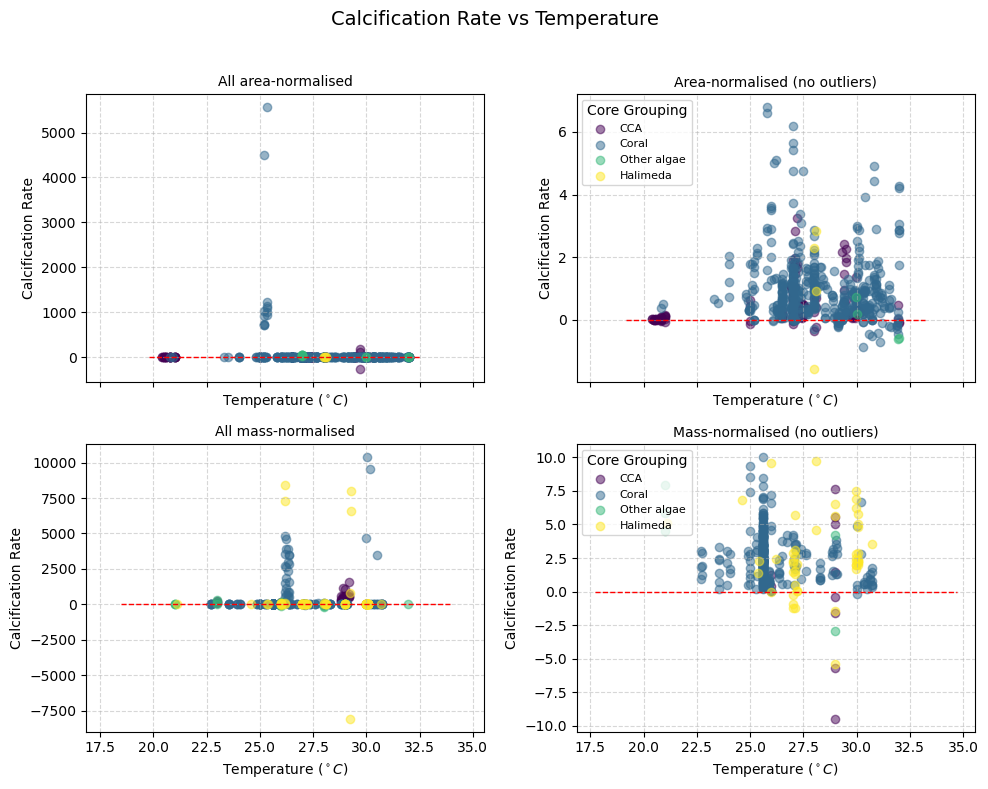

In [46]:
### naive plotting of calcification rates against absolute values of temperature
### for two main unit subsets (mgCaCO3 cm-2d-1 and mgCaCO3 g-1d-1)
area_norm_df = working_df[working_df['st_calcification_unit'] == 'mgCaCO3 cm-2d-1'].copy()
mass_norm_df = working_df[working_df['st_calcification_unit'] == 'mgCaCO3 g-1d-1'].copy()

# TODO: these currently assigned by sight due to large inherent variance
area_norm_no_outliers_df = area_norm_df[
    (area_norm_df.st_calcification > -10) &
    (area_norm_df.st_calcification < 10)
]   
mass_norm_no_outliers_df = mass_norm_df[
    (mass_norm_df.st_calcification > -10) &
    (mass_norm_df.st_calcification < 10)
]


fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_df['core_grouping'].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_df['core_grouping'].nunique()))
    )
}

plots = [
    (0, 0, area_norm_df, 'All area-normalised'),
    (0, 1, area_norm_no_outliers_df, 'Area-normalised (no outliers)'),
    (1, 0, mass_norm_df, 'All mass-normalised'),
    (1, 1, mass_norm_no_outliers_df, 'Mass-normalised (no outliers)')
]

for row, col, df, title in plots:
    ax = axes[row][col]
    for group, color in group_color_map.items():
        subset = df[df['core_grouping'] == group]
        ax.scatter(subset['temp'], subset['st_calcification'], color=color, label=group, alpha=0.5)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Temperature ($^\\circ C$)')
    ax.set_ylabel('Calcification Rate')
    ax.grid(ls='--', alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color='red', linestyle='--', linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc='upper left', fontsize=8)

fig.suptitle('Calcification Rate vs Temperature', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle


In [ ]:
### naive plotting of calcification rates against absolute values of pH
### for two main unit subsets (mgCaCO3 cm-2d-1 and mgCaCO3 g-1d-1)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_df['core_grouping'].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_df['core_grouping'].nunique()))
    )
}

plots = [
    (0, 0, area_norm_df, 'Area-normalised'),
    (0, 1, area_norm_no_outliers_df, 'Area-normalised (no outliers)'),
    (1, 0, mass_norm_df, 'Mass-normalised'),
    (1, 1, mass_norm_no_outliers_df, 'Mass-normalised (no outliers)')
]

for row, col, df, title in plots:
    ax = axes[row][col]
    for group, color in group_color_map.items():
        subset = df[df['core_grouping'] == group]
        ax.scatter(subset['phtot'], subset['st_calcification'], color=color, label=group, alpha=0.5)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('pH$_T$')
    ax.set_ylabel('Calcification Rate')
    ax.grid(ls='--', alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color='red', linestyle='--', linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc='upper left', fontsize=8)

fig.suptitle('Calcification Rate vs pH$_T$', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


In [ ]:
### 3D plot with calcification on the z axis, and temperature/phtot on the x/y axis
### Area normalised first

import plotly.express as px
# create helper column to weight points by the inverse of their standard deviation
# points_weights = 1/test['st_calcification_sd']

area_norm_no_outliers_df.loc[:, 'points_weights'] = np.sqrt(area_norm_no_outliers_df['st_calcification_sd'])

px.scatter_3d(
    area_norm_no_outliers_df,
    x='temp',
    y='phtot',
    z='st_calcification',
    color='core_grouping',
    title='3D Scatter plot of Standardized Calcification vs Temperature and pH',
    labels={'temp': 'Temperature', 'phtot': 'pH', 'st_calcification': 'Standardized Calcification'},
    hover_name='species_types',
    opacity=0.5,
    size='points_weights',
    width=800,
    height=800,
)


In [ ]:
### 3D plot with calcification on the z axis, and temperature/phtot on the x/y axis
### Mass normalised

mass_norm_no_outliers_df.loc[:, 'points_weights'] = np.sqrt(mass_norm_no_outliers_df['st_calcification_sd'])

px.scatter_3d(
    mass_norm_no_outliers_df,
    x='temp',
    y='phtot',
    z='st_calcification',
    color='core_grouping',
    title='3D Scatter plot of Standardized Calcification vs Temperature and pH',
    labels={'temp': 'Temperature', 'phtot': 'pH', 'st_calcification': 'Standardized Calcification'},
    hover_name='species_types',
    opacity=0.5,
    size='points_weights',
    width=800,
    height=800,
)


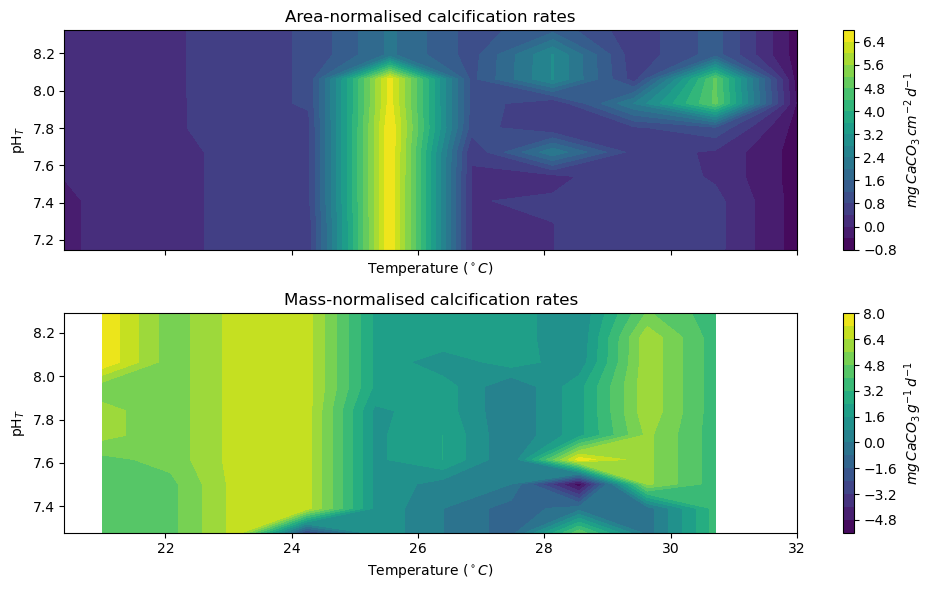

In [49]:
### contour plot of calcification rates against temperature and pH

fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
npoints = 10


area_x = np.linspace(area_norm_no_outliers_df.temp.min(), area_norm_no_outliers_df.temp.max(), npoints)  # Temperature range
area_y = np.linspace(area_norm_no_outliers_df.phtot.min(), area_norm_no_outliers_df.phtot.max(), npoints)  # pH range
mass_x = np.linspace(mass_norm_no_outliers_df.temp.min(), mass_norm_no_outliers_df.temp.max(), npoints)  # Temperature range
mass_y = np.linspace(mass_norm_no_outliers_df.phtot.min(), mass_norm_no_outliers_df.phtot.max(), npoints)  # pH range
plotting.plot_contour(ax[0], area_x, area_y, area_norm_no_outliers_df, 'Area-normalised calcification rates', legend_label=r'$mg \, CaCO_3 \, cm^{-2} \, d^{-1}$')
plotting.plot_contour(ax[1], mass_x, mass_y, mass_norm_no_outliers_df, 'Mass-normalised calcification rates', legend_label=r'$mg \, CaCO_3 \, g^{-1} \, d^{-1}$')

plt.tight_layout()

## Effect sizes

In the assignment of treatment groups, two studies show up as problematic (no control). This is because calcification rates from explicitly-adapted corals (e.g. those near local CO2 seeps) have not been recorded. **Is this fair**? There are in fact a number of studies currently excluded due to this sort of thing. But it'd be interesting to see how these tally all together, perhaps in their own meta-analysis.

In [ ]:
### generating effect sizes
effects_df = analysis.calculate_effect_for_df(working_df).reset_index(drop=True)
# errors thrown up re no control data due to questionable studies (excluding explicitly adapted studies)
print(f'Shape of dataframe with effect sizes: {effects_df.shape}')
print(effects_df['treatment'].value_counts())
working_effects_df = effects_df.copy()
effect_sizes=['cohens_d', 'hedges_g', 'relative_calcification', 'absolute_calcification', 'st_relative_calcification', 'st_absolute_calcification']

  0%|          | 0/150 [00:00<?, ?it/s]

No control data found for this group (index Index([222], dtype='int64') DOI 10.3389/fmars.2020.581160 species Pocillopora acuta)
No control data found for this group (index Index([1194], dtype='int64') DOI 10.1007/s00227-012-2001-y species Porites spp.)
Shape of dataframe with effect sizes: (1012, 113)
treatment
phtot         592
temp          254
temp_phtot    166
Name: count, dtype: int64


In [ ]:
plotting.plot_effect_size_distributions(
    working_effects_df, title='Effect size distributions (all studies)',
)

In [ ]:
plotting.plot_effect_size_distributions(
    working_effects_df[working_effects_df['st_calcification_unit'] == 'mgCaCO3 cm-2d-1'], title='Effect size distributions (area-normalised calcification rates)',
)


In [ ]:
plotting.plot_effect_size_distributions(
    working_effects_df[working_effects_df['st_calcification_unit'] == 'mgCaCO3 g-1d-1'], title='Effect size distributions (mass-normalised calcification rates)',
)

In [ ]:
### break down effect size by core_grouping
fig, axes = plt.subplots(len(effect_sizes), 1, figsize=(10, 10), sharex=False)

for i, effect_size in enumerate(effect_sizes):
    # plot the effect sizes for each core grouping
    sns.boxplot(
        data=working_effects_df,
        x=effect_size,
        y='core_grouping',
        palette='vlag',
        hue='core_grouping',
        ax=axes[i],
    )
    sns.stripplot(
        data=working_effects_df,
        x=effect_size,
        y='core_grouping',
        ax=axes[i],
        alpha=0.3,
        marker='x',
        s=1,
        color='black',  # Ensure this is the desired color
        linewidth=1  # Optional: Add a line width for better visibility
    )
    axes[i].vlines(
        x=0,
        ymin=-0.5,
        ymax=len(working_effects_df['core_grouping'].unique()) - 0.5,
        color='black',
        linestyle='--',
        linewidth=1,
        zorder=10
    )
    axes[i].set_ylabel('')
plt.tight_layout()

Text(0.5, 1.0, 'Number of effect sizes per core grouping')

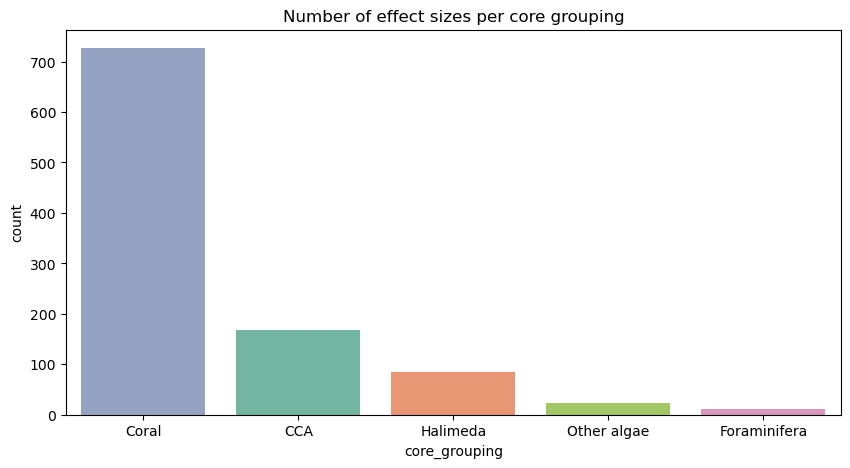

In [51]:
### visualise the number of effect sizes per core grouping
fig, ax = plt.subplots(figsize=(10, 5))
# order by number of effect sizes
count_order = working_effects_df['core_grouping'].value_counts().index
# plot the number of effect sizes per core grouping
sns.countplot(
    data=working_effects_df,
    x='core_grouping',
    order=count_order,
    palette='Set2',
    hue='core_grouping',
)
plt.title('Number of effect sizes per core grouping')

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

# TODO: better colour map
fig, ax = plt.subplots(figsize=(12, 6), dpi=300,
                       subplot_kw={'projection': ccrs.PlateCarree()})
ax = plotting.format_geo_axes(ax)  # your custom axis formatter

# Color map for different groups (adjust or use your own)
unique_groups = working_effects_df['core_grouping'].unique()
group_colors = {grp: color for grp, color in zip(unique_groups, plt.cm.Set3.colors)}

# Loop over each unique study (DOI)
for doi, group in working_effects_df.groupby('doi'):
    
    if group['latitude'].isna().any() or group['longitude'].isna().any():
        print(f"Skipping DOI {doi} due to missing latitude/longitude.")
        continue
    lat = group['latitude'].values[0]
    lon = group['longitude'].values[0]

    # Count how many effect sizes per core_grouping within this DOI
    group_counts = group['core_grouping'].value_counts()
    
    # Skip if nothing to plot or if any counts are zero
    if group_counts.empty or group_counts.sum() == 0:
        continue
        
    sizes = group_counts.values
    labels = group_counts.index
    
    # Make sure we only plot groups with non-zero counts
    valid_indices = [i for i, size in enumerate(sizes) if size > 0]
    if not valid_indices:  # Skip if no valid data
        continue
        
    # Filter to only include groups with non-zero counts
    sizes = [sizes[i] for i in valid_indices]
    labels = [labels[i] for i in valid_indices]
    colors = [group_colors[labels[i]] for i in valid_indices]

    # Scale pie chart size by total number of effect sizes
    n_effect_sizes = sum(sizes)
    size = 0.05 + n_effect_sizes * 0.002  # tweak as needed

    # Create inset axis at the study's geographic location
    pie_ax = inset_axes(ax,
                        width=size,
                        height=size,
                        loc='center',
                        bbox_to_anchor=(lon, lat),
                        bbox_transform=ax.transData,
                        borderpad=0,
                        )

    # Only create pie charts with valid data
    if len(sizes) > 0:
        wedges, _ = pie_ax.pie(sizes, colors=colors, startangle=90, wedgeprops={'edgecolor': 'darkgrey', 'linewidth': 0.5})
        pie_ax.set_aspect("equal")
        pie_ax.axis('off')  # hide pie chart axis

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=group_colors[grp], label=str(grp)) 
                  for grp in unique_groups]
ax.legend(handles=legend_elements,
         loc='lower center', bbox_to_anchor=(0.5, -0.2), ncols=len(unique_groups), fontsize=8,
         )

In [ ]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import numpy as np
# from matplotlib.patches import Patch, Circle

# # TODO: better colour map
# fig, ax = plt.subplots(figsize=(12, 6), dpi=300,
#                        subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plotting.format_geo_axes(ax)  # your custom axis formatter

# # Color map for different groups (adjust or use your own)
# unique_groups = working_effects_df['core_grouping'].unique()
# group_colors = {grp: color for grp, color in zip(unique_groups, plt.cm.Set3.colors)}

# # Track the min and max number of effect sizes
# min_effects = float('inf')
# max_effects = 0

# # First pass to determine size range
# for doi, group in working_effects_df.groupby('doi'):
#     if group['latitude'].isna().any() or group['longitude'].isna().any():
#         continue
    
#     group_counts = group['core_grouping'].value_counts()
#     if group_counts.empty or group_counts.sum() == 0:
#         continue
    
#     n_effect_sizes = group_counts.sum()
#     min_effects = min(min_effects, n_effect_sizes)
#     max_effects = max(max_effects, n_effect_sizes)

# # Function to calculate size from effect count
# def calculate_size(n_effects):
#     return 0.05 + n_effects * 0.002

# # Loop over each unique study (DOI)
# for doi, group in working_effects_df.groupby('doi'):
#     if group['latitude'].isna().any() or group['longitude'].isna().any():
#         print(f"Skipping DOI {doi} due to missing latitude/longitude.")
#         continue
#     lat = group['latitude'].values[0]
#     lon = group['longitude'].values[0]

#     # Count how many effect sizes per core_grouping within this DOI
#     group_counts = group['core_grouping'].value_counts()
    
#     # Skip if nothing to plot or if any counts are zero
#     if group_counts.empty or group_counts.sum() == 0:
#         continue
        
#     sizes = group_counts.values
#     labels = group_counts.index
    
#     # Make sure we only plot groups with non-zero counts
#     valid_indices = [i for i, size in enumerate(sizes) if size > 0]
#     if not valid_indices:  # Skip if no valid data
#         continue
        
#     # Filter to only include groups with non-zero counts
#     sizes = [sizes[i] for i in valid_indices]
#     labels = [labels[i] for i in valid_indices]
#     colors = [group_colors[labels[i]] for i in valid_indices]

#     # Scale pie chart size by total number of effect sizes
#     n_effect_sizes = sum(sizes)
#     size = calculate_size(n_effect_sizes)

#     # Create inset axis at the study's geographic location
#     pie_ax = inset_axes(ax,
#                         width=size,
#                         height=size,
#                         loc='center',
#                         bbox_to_anchor=(lon, lat),
#                         bbox_transform=ax.transData,
#                         borderpad=0,
#                         )

#     # Only create pie charts with valid data
#     if len(sizes) > 0:
#         wedges, _ = pie_ax.pie(sizes, colors=colors, startangle=90, wedgeprops={'edgecolor': 'darkgrey', 'linewidth': 0.5})
#         pie_ax.set_aspect("equal")
#         pie_ax.axis('off')  # hide pie chart axis

# # Group color legend
# group_legend_elements = [Patch(facecolor=group_colors[grp], label=str(grp)) 
#                   for grp in unique_groups]
# group_legend = ax.legend(handles=group_legend_elements,
#                          loc='lower center', bbox_to_anchor=(0.5, -0.2), 
#                          ncols=len(unique_groups), fontsize=8,
#                          title="Core grouping")

# plt.tight_layout()

# # TODO: add legend for effect sizes
# # from matplotlib.legend_handler import HandlerPatch

# # # Create proxy artists for circle sizes
# # class HandlerCircle(HandlerPatch):
# #     def create_artists(self, legend, orig_handle,
# #                        xdescent, ydescent, width, height, fontsize, trans):
# #         center = (width / 2, height / 2)
# #         p = Circle(xy=center, radius=orig_handle.get_radius())
# #         self.update_prop(p, orig_handle, legend)
# #         p.set_transform(trans)
# #         return [p]

# # # Create example circles with corresponding sizes
# # min_circle = Circle((0, 0), radius=min_size/2, facecolor='lightgrey', edgecolor='darkgrey')
# # max_circle = Circle((0, 0), radius=max_size/2, facecolor='lightgrey', edgecolor='darkgrey')

# # # Create the legend using proxy artists
# # size_legend = ax.legend([min_circle, max_circle],
# #                         [f"{min_effects}", f"{max_effects} effect size(s)"],
# #                         handler_map={Circle: HandlerCircle()},
# #                         loc='lower right', bbox_to_anchor=(1, 0.75),
# #                         title="Effect sizes",
# #                         fontsize=8)
# # ax.add_artist(group_legend)  # Keep the original grouping legend
# # ax.add_artist(size_legend)   # Add the new size legend



In [ ]:
### plot distribution of delta ph and delta_t
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
# Plot delta_t
sns.histplot(
    data=working_effects_df,
    x='delta_t',
    bins=50,
    ax=axes[0],
)
axes[0].set_xlabel('$\\Delta$ Temperature ($^\\circ C$)')
# Plot delta_pH
sns.histplot(
    data=working_effects_df,
    x='delta_ph',
    bins=50,
    ax=axes[1],
)
axes[1].set_xlabel('$\\Delta$ pH')
plt.tight_layout()

## ANOVA

Doing a very basic analysis, starting with a single study

## Meta-regression

In [ ]:
# set effect type for all proceeding cells
effect_type = "hedges_g"

In [ ]:
### run meta-analysis
basic_ph_model, basic_ph_model_summary, basic_ph_model_formula, ph_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='phtot',
)

basic_temp_model, basic_temp_model_summary, basic_temp_model_formula, temp_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='temp',
)

In [ ]:
print(basic_ph_model_summary)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the pH meta-regression
var = 'phtot'
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=basic_ph_model,
    model_comps = analysis.get_formula_components(basic_ph_model_formula),
    x_mod = 'delta_ph',
    pi=False,
    xlim=xlim,
    xlab=xlab,
    predlim=xlim,
    ax=axes[0],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var=scenario_var,
)
axes[0].set_title("pH Meta-Regression")
plotting.add_climatology_lines_to_plot(ph_reg_ax, future_global_anomaly_df, scenario_var, xlim)

# Plot the temperature meta-regression
var = 'temp'
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, temp_reg_ax = plotting.meta_regplot(
    model=basic_temp_model,
    model_comps = analysis.get_formula_components(basic_temp_model_formula),
    x_mod = 'delta_t',
    pi=False,
    xlim=xlim,
    xlab=xlab,
    predlim=xlim,
    ax=axes[1],
)
plotting.add_climatology_lines_to_plot(temp_reg_ax, future_global_anomaly_df, scenario_var, xlim)
axes[1].set_title("Temperature Meta-Regression")

plt.tight_layout()
plt.show()

In [ ]:
### run meta-analysis
delta_and_absolute_ph_model, delta_and_absolute_ph_model_summary, delta_and_absolute_ph_model_formula, ph_df  = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='phtot',
    necessary_vars=['phtot'],
)

delta_and_absolute_temp_model, delta_and_absolute_temp_model_summary, delta_and_absolute_temp_model_formula, temp_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='temp',
    necessary_vars=['temp'],
)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the pH meta-regression
var = 'phtot'
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=delta_and_absolute_ph_model,
    model_comps = analysis.get_formula_components(delta_and_absolute_ph_model_formula),
    x_mod = 'delta_ph',
    pi=False,
    predlim=xlim,
    xlim=xlim,
    xlab=xlab,
    ax=axes[0],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var=scenario_var,
)
axes[0].set_title("pH Meta-Regression")
plotting.add_climatology_lines_to_plot(ph_reg_ax, future_global_anomaly_df, scenario_var, xlim)

# Plot the temperature meta-regression
var = 'temp'
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, temp_reg_ax = plotting.meta_regplot(
    model=delta_and_absolute_temp_model,
    model_comps = analysis.get_formula_components(delta_and_absolute_temp_model_formula),
    x_mod = 'delta_t',
    pi=False,
    predlim=xlim,
    xlim=xlim,
    xlab=xlab,
    ax=axes[1],
)
plotting.add_climatology_lines_to_plot(temp_reg_ax, future_global_anomaly_df, scenario_var, xlim)
axes[1].set_title("Temperature Meta-Regression")

plt.tight_layout()
plt.show()

In [ ]:
### run meta-analysis
multivariable_ph_model, multivariable_ph_model_summary, multivariable_ph_model_formula, ph_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='phtot',
    necessary_vars=['temp'],
)

multivariable_temp_model, multivariable_temp_model_summary, multivariable_temp_model_formula, temp_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='temp',
    necessary_vars=['phtot'],
)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot the pH meta-regression
var = 'phtot'
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=multivariable_ph_model,
    model_comps = analysis.get_formula_components(multivariable_ph_model_formula),
    x_mod = 'delta_ph',
    pi=False,
    xlab=xlab,
    xlim=xlim,
    predlim=xlim,
    ax=axes[0],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var=scenario_var,
)
axes[0].set_title("pH Meta-Regression")
plotting.add_climatology_lines_to_plot(ph_reg_ax, future_global_anomaly_df, scenario_var, xlim)

# Plot the temperature meta-regression
var = 'temp'
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, temp_reg_ax = plotting.meta_regplot(
    model=multivariable_temp_model,
    model_comps = analysis.get_formula_components(multivariable_temp_model_formula),
    x_mod = 'delta_t',
    pi=False,
    xlab=xlab,
    predlim=xlim,
    xlim=xlim,
    ax=axes[1], 
)
plotting.add_climatology_lines_to_plot(temp_reg_ax, future_global_anomaly_df, scenario_var, xlim)
axes[1].set_title("Temperature Meta-Regression")

plt.tight_layout()
plt.show()

In [ ]:
### run meta-analysis
basic_with_cgs_ph_model, basic_with_cgs_ph_model_summary, basic_with_cgs_ph_model_formula, ph_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='phtot',
    necessary_vars=['core_grouping'],
)

basic_with_cgs_temp_model, basic_with_cgs_temp_model_summary, basic_with_cgs_temp_model_formula, temp_df = analysis.run_metafor_mv(
    working_effects_df,
    effect_type=effect_type,
    treatment='temp',
    necessary_vars=['core_grouping'],
)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

var = 'phtot'   # Plot the pH meta-regression
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, ph_reg_ax = plotting.meta_regplot(
    model=basic_with_cgs_ph_model,
    model_comps = analysis.get_formula_components(basic_with_cgs_ph_model_formula),
    x_mod = 'delta_ph',
    pi=False,
    xlab=xlab,
    predlim=xlim,
    xlim=xlim,
    ax=axes[0],
    future_global_anomaly_df=future_global_anomaly_df,
    scenario_var=scenario_var,
)
axes[0].set_title("pH Meta-Regression")
plotting.add_climatology_lines_to_plot(ph_reg_ax, future_global_anomaly_df, scenario_var, xlim)


var = 'temp'    # Plot the temperature meta-regression
xlab, xlim, predlim, scenario_var = plotting.set_up_regression_plot(var)
reg_fig, temp_reg_ax = plotting.meta_regplot(
    model=basic_with_cgs_temp_model,
    model_comps = analysis.get_formula_components(basic_with_cgs_temp_model_formula),
    x_mod = 'delta_t',
    pi=False,
    xlab=xlab,
    predlim=xlim,
    xlim=xlim,
    ax=axes[1],
)
plotting.add_climatology_lines_to_plot(temp_reg_ax, future_global_anomaly_df, scenario_var, xlim)
axes[1].set_title("Temperature Meta-Regression")

plt.tight_layout()
plt.show()

## More formally: using MuMIn

In [ ]:
temp_formula, temp_df = analysis.preprocess_df_for_meta_model(working_effects_df, treatment='temp', necessary_vars=['temp', 'phtot'])
analysis.run_parallel_dredge(temp_df, global_formula="hedges_g ~ temp * phtot - 1", n_cores=16)

## Incorporating climatology into regressions

In [ ]:
# combine climatology and effects DataFrames, keeping only the first occurrence of shared columns
working_clim_effects_df = working_clim_df.reset_index().drop_duplicates(
    subset=['longitude', 'latitude'],
    keep='first',
).merge(
    working_effects_df,
    how='right',
    left_on=['longitude', 'latitude'],
    right_on=['longitude', 'latitude'],
    suffixes=('', '_duplicate')
)

# drop duplicate columns (those with '_duplicate' suffix)
working_clim_effects_df = working_clim_effects_df.loc[:, ~working_clim_effects_df.columns.str.endswith('_duplicate')]

In [ ]:
# calculate delta_t_clim and delta_ph_clim (mean_historical_sst_30y_ensemble and mean_historical_ph_30y_ensemble minus the phtot and temp columns)
working_clim_effects_df['delta_t_clim'] = working_clim_effects_df['temp'] - working_clim_effects_df['mean_historical_sst_30y_ensemble']
working_clim_effects_df['delta_ph_clim'] = working_clim_effects_df['phtot'] - working_clim_effects_df['mean_historical_ph_30y_ensemble']

# plot histograms of delta_t_clim and delta_ph_clim
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
# Plot delta_t_clim
sns.histplot(
    data=working_clim_effects_df,
    x='delta_t_clim',
    bins=50,
    ax=axes[0],
)
axes[0].set_xlabel('$\\Delta$ Temperature ($^\\circ C$)')
# Plot delta_ph_clim
sns.histplot(
    data=working_clim_effects_df,
    x='delta_ph_clim',
    bins=50,
    ax=axes[1],
)
axes[1].set_xlabel('$\\Delta$ pH')
plt.suptitle('Experimental-climatological condition anomalies')
plt.tight_layout()

In [ ]:
### TODO: does it make sense just to plot climatology anomalies against raw calcification rates?

### scatter of climatology anomalies against calcification rates
area_norm_clim_df = working_clim_effects_df[working_clim_effects_df['st_calcification_unit'] == 'mgCaCO3 cm-2d-1'].copy()
mass_norm_clim_df = working_clim_effects_df[working_clim_effects_df['st_calcification_unit'] == 'mgCaCO3 g-1d-1'].copy()

# TODO: these currently assigned by sight due to large inherent variance
area_norm_clim_no_outliers_df = area_norm_clim_df[
    (area_norm_clim_df.st_calcification > -10) &
    (area_norm_clim_df.st_calcification < 10)
]   
mass_norm_clim_no_outliers_df = mass_norm_clim_df[
    (mass_norm_clim_df.st_calcification > -10) &
    (mass_norm_clim_df.st_calcification < 10)
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_clim_df['core_grouping'].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_clim_df['core_grouping'].nunique()))
    )
}

plots = [
    (0, 0, area_norm_clim_df, 'Area-normalised'),
    (0, 1, area_norm_clim_no_outliers_df, 'Area-normalised (no outliers)'),
    (1, 0, mass_norm_clim_df, 'Mass-normalised'),
    (1, 1, mass_norm_clim_no_outliers_df, 'Mass-normalised (no outliers)')
]

for row, col, df, title in plots:
    ax = axes[row][col]
    for group, color in group_color_map.items():
        subset = df[df['core_grouping'] == group]
        ax.scatter(subset['delta_ph_clim'], subset['st_calcification'], color=color, label=group, alpha=0.5)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('pH$_T$')
    ax.set_ylabel('Calcification Rate')
    ax.grid(ls='--', alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color='red', linestyle='--', linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc='upper left', fontsize=8)

fig.suptitle('Calcification Rate vs $\\Delta$ pH$_T$ wrt historic climatology', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


In [ ]:
### wrt temperature climatology
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
group_color_map = {
    group: color
    for group, color in zip(
        area_norm_clim_df['core_grouping'].dropna().unique(),
        plt.cm.viridis(np.linspace(0, 1, area_norm_clim_df['core_grouping'].nunique()))
    )
}

plots = [
    (0, 0, area_norm_clim_df, 'Area-normalised'),
    (0, 1, area_norm_clim_no_outliers_df, 'Area-normalised (no outliers)'),
    (1, 0, mass_norm_clim_df, 'Mass-normalised'),
    (1, 1, mass_norm_clim_no_outliers_df, 'Mass-normalised (no outliers)')
]

for row, col, df, title in plots:
    ax = axes[row][col]
    for group, color in group_color_map.items():
        subset = df[df['core_grouping'] == group]
        ax.scatter(subset['delta_t_clim'], subset['st_calcification'], color=color, label=group, alpha=0.5)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('$\\Delta$ Temperature ($^\\circ$C)')
    ax.set_ylabel('Calcification Rate')
    ax.grid(ls='--', alpha=0.5)
    ax.hlines(0, *ax.get_xlim(), color='red', linestyle='--', linewidth=1)
    if col == 1:
        ax.legend(title="Core Grouping", loc='upper left', fontsize=8)

fig.suptitle('Calcification Rate vs $\\Delta$ Temperature wrt historic climatology', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.show()


## Extending to predictions

In [ ]:
sst_all = pd.DataFrame(analysis.generate_location_specific_predictions(
    model=basic_temp_model_summary,
    df=working_clim_df,
    scenario_var='sst'
))
sst_preds = sst_all.groupby(['scenario', 'time_frame', 'percentile'])[['anomaly_value', 'predicted_effect_size']].mean().reset_index()
sst_preds_shortform = sst_preds.pivot(index=['scenario', 'time_frame'], columns='percentile', values=['anomaly_value', 'predicted_effect_size'])
sst_preds_shortform.columns = ['_'.join(col).strip() for col in sst_preds_shortform.columns.values]
sst_preds_shortform.reset_index(inplace=True)
# sst_preds_shortform.set_index(['scenario', 'time_frame'], inplace=True)

ph_all = pd.DataFrame(analysis.generate_location_specific_predictions(
    model=basic_ph_model_summary,
    df=working_clim_df,
    scenario_var='ph'
))
ph_preds = ph_all.groupby(['scenario', 'time_frame', 'percentile'])[['anomaly_value', 'predicted_effect_size']].mean().reset_index()
ph_preds_shortform = ph_preds.pivot(index=['scenario', 'time_frame'], columns='percentile', values=['anomaly_value', 'predicted_effect_size'])
ph_preds_shortform.columns = ['_'.join(col).strip() for col in ph_preds_shortform.columns.values]
ph_preds_shortform.reset_index(inplace=True)
# ph_preds_shortform.set_index(['scenario', 'time_frame'], inplace=True)
ph_preds_shortform['scenario_var'] = 'ph'
sst_preds_shortform['scenario_var'] = 'sst'

predictions_shortform = pd.concat([sst_preds_shortform, ph_preds_shortform], axis=0)
spatial_predictions = pd.concat([sst_all, ph_all], axis=0)

In [ ]:
_,_ = plotting.plot_global_timeseries(predictions_shortform, plot_vars=['sst', 'ph'], figsize=(10, 10), dpi=300)

In [ ]:
spatial_predictions_sst = spatial_predictions[spatial_predictions['scenario_var'] == 'sst']
spatial_fig_sst,_ = plotting.plot_spatial_effect_distribution(spatial_predictions_sst, time_frame=2090, figsize=(7, 7), dpi=300, reverse_cmap=True)

## Bioerosion end-to-end